In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset, Subset
import numpy as np
import tft_model
from data_formatters import ts_dataset  
import data_formatters.base
import expt_settings.configs
import importlib
from data_formatters import utils
import torch.optim as optim
import torch
from pandas import DataFrame
from typing import List, Dict

In [3]:
torch.__version__

'1.8.1+cu101'

In [4]:
pd.set_option('max_columns', 1000)

In [5]:
importlib.reload(tft_model)
importlib.reload(utils)

<module 'data_formatters.utils' from '..\\data_formatters\\utils.py'>

In [6]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('electricity', '../outputs')
data_formatter = config.make_data_formatter()


print("*** Training from defined parameters for {} ***".format('electricity'))
data_csv_path = '../data/hourly_electricity.csv'
print("Loading & splitting data...")
raw_data: DataFrame = pd.read_csv(data_csv_path, index_col=0)
train, valid, test = data_formatter.split_data(raw_data)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
)

# Sets up default params
fixed_params: Dict = data_formatter.get_experiment_params()
params: Dict = data_formatter.get_default_model_params()

*** Training from defined parameters for electricity ***
Loading & splitting data...


C:\Users\Lorenzo\PycharmProjects\Temporal_Fusion_Transform\venv\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Formatting train-valid-test splits.
Setting scalers with training data...


In [7]:
len(train.id.unique())

369

In [8]:
train.head()

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
17544,-0.127174,26304.0,1096,0,2014-01-01 00:00:00,MT_001,-1.661325,1,-0.499719,1,-1.731721,2,0
17545,-0.050713,26305.0,1096,0,2014-01-01 01:00:00,MT_001,-1.516862,1,-0.499719,1,-1.731062,2,1
17546,-0.050713,26306.0,1096,0,2014-01-01 02:00:00,MT_001,-1.372399,1,-0.499719,1,-1.730403,2,2
17547,-0.050713,26307.0,1096,0,2014-01-01 03:00:00,MT_001,-1.227936,1,-0.499719,1,-1.729744,2,3
17548,-0.127174,26308.0,1096,0,2014-01-01 04:00:00,MT_001,-1.083473,1,-0.499719,1,-1.729085,2,4


In [9]:
train.columns

Index(['power_usage', 't', 'days_from_start', 'categorical_id', 'date', 'id',
       'hour', 'day', 'day_of_week', 'month', 'hours_from_start',
       'categorical_day_of_week', 'categorical_hour'],
      dtype='object')

In [10]:
id_col = 'id'
time_col='hours_from_start'
input_cols =['power_usage', 'hour', 'day_of_week', 'hours_from_start', 'categorical_id']
target_col = 'power_usage'
static_cols = ['categorical_id']
time_steps=192
num_encoder_steps = 168
output_size = 1
max_samples = 1000
input_size = 5

elect = ts_dataset.TSDataset(id_col, static_cols, time_col, input_cols,
                      target_col, time_steps, max_samples,
                     input_size, num_encoder_steps, 1, output_size, train)

Getting valid sampling locations.
Extracting 1000 samples...


In [11]:
batch_size=64
loader = DataLoader(
            elect,
            batch_size=batch_size,
            num_workers=2,
            shuffle=False
        )

In [12]:
for batch in loader:
    break

In [13]:
static_cols = ['meter']
categorical_cols = ['hour']
real_cols = ['power_usage','hour', 'day']
config = {}
config['static_variables'] = len(static_cols)
config['time_varying_categoical_variables'] = 1
config['time_varying_real_variables_encoder'] = 4
config['time_varying_real_variables_decoder'] = 3
config['num_masked_series'] = 1
config['static_embedding_vocab_sizes'] = [369]
config['time_varying_embedding_vocab_sizes'] = [369]
config['embedding_dim'] = 8
config['lstm_hidden_dimension'] = 160
config['lstm_layers'] = 1
config['dropout'] = 0.05
config['device'] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
config['batch_size'] = 64
config['encode_length'] = 168
config['attn_heads'] = 4
config['num_quantiles'] = 3
config['vailid_quantiles'] = [0.1,0.5,0.9]
config['seq_length'] = 192

In [14]:
config

{'static_variables': 1,
 'time_varying_categoical_variables': 1,
 'time_varying_real_variables_encoder': 4,
 'time_varying_real_variables_decoder': 3,
 'num_masked_series': 1,
 'static_embedding_vocab_sizes': [369],
 'time_varying_embedding_vocab_sizes': [369],
 'embedding_dim': 8,
 'lstm_hidden_dimension': 160,
 'lstm_layers': 1,
 'dropout': 0.05,
 'device': device(type='cuda', index=0),
 'batch_size': 64,
 'encode_length': 168,
 'attn_heads': 4,
 'num_quantiles': 3,
 'vailid_quantiles': [0.1, 0.5, 0.9],
 'seq_length': 192}

In [15]:
model = tft_model.TFT(config)


C:\Users\Lorenzo\PycharmProjects\Temporal_Fusion_Transform\venv\lib\site-packages\torch\nn\modules\rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [16]:
output,encoder_output, decoder_output, \
attn,attn_output_weights, embeddings_encoder, embeddings_decoder = model.forward(batch)

..\tft_model.py:190: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sparse_weights = self.softmax(sparse_weights).unsqueeze(2)


In [17]:
output.shape

torch.Size([64, 24, 3])

In [18]:
q_loss_func = tft_model.QuantileLoss([0.1,0.5,0.9])

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()
epochs=100
losses = []
for i in range(epochs):
    epoch_loss = [] 
    j=0
    for batch in loader:
        output, encoder_ouput, decoder_output, attn, attn_weights, emb_enc, emb_dec = model(batch)
        targets = batch['outputs']
        targets = targets.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
        print(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
        loss = q_loss_func(output[:,:,:].view(-1,3), targets[:,:,0].flatten().float())
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        j+=1
        if j>5:
            break
    losses.append(np.mean(epoch_loss))
    print(np.mean(epoch_loss))
    

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.2111035982767742
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.2043326099713643
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.1967796285947163
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.1875662803649902
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.1756251454353333
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.1596033175786336
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.1388221581776936
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.1125621596972148
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.0822203954060872
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.0499005715052288
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.057167410850525
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.0027023156483967
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.0981822808583577
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.0908500750859578
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
1.0594177842140198
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
0.9962103764216105
cuda:0
cuda:0
cuda:0
cuda

In [23]:
output, encoder_ouput, decoder_output, attn, attn_weights, emb_enc, emb_dec = model(batch)

In [24]:
output.shape

torch.Size([64, 24, 3])

58


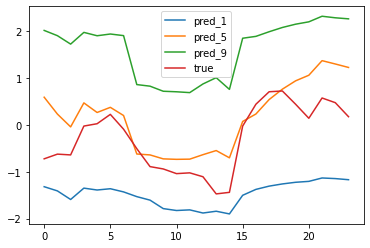

In [25]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.random.choice(64)
print(ind)
plt.plot(output[ind,:,0].detach().cpu().numpy(), label='pred_1')
plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred_5')
plt.plot(output[ind,:,2].detach().cpu().numpy(), label='pred_9')

plt.plot(batch['outputs'][ind,:,0], label='true')
plt.legend()

In [26]:
attn_weights.shape

torch.Size([64, 24, 168])

In [27]:
plt.matshow(attn_weights.detach().numpy()[0,:,:])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
plt.imshow(attn_weights.detach().numpy()[0,:,:])